# Result Visualizer

Different visualizations of anomaly detection result, including forecasts, reconstructions, anomaly scores, predicted and actual anomalies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
import pickle
from sklearn.metrics import f1_score, precision_score, recall_score
import plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode
import plotly.graph_objs as go
import cufflinks as cf
import glob
import sys
import json
import more_itertools as mit
cf.go_offline()
init_notebook_mode

sys.path.insert(0, '..')
from plotting import Plotter

from tqdm.notebook import tqdm

os.environ["JUPYTER_ALLOW_INSECURE_WRITES"] = "1"


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

### Specify data result to visualize

In [ ]:
dir_path = f"../output/SMD/3-11"
dir_content = os.listdir(dir_path)
subfolders = [subf for subf in dir_content if os.path.isdir(f"{dir_path}/{subf}") and subf != "logs" and not subf.startswith("site_")]
print(subfolders)
subfolders.sort()
model_id = subfolders[-1]

output_path = f"{dir_path}/{model_id}"

In [3]:
all_sites = ["S0142","S0185","S0260","S0278","S0361","S0362","S0405","S0453","S1076","S1079","S1084","S1117","S1222","S1285","S1336","S1377","S1693","S1950","S2126","S3005","S3009","S3145","S3285","S3375","S3376","S3379","S3539","S3562","S3686","S4002","S4093","S4097","S4328","S4727"]

In [64]:
from random import choice
site = choice(all_sites)
site = "S1377"
print(site)

dir_path = f"../output/TELENOR/{site.upper()}"
dir_content = os.listdir(dir_path)
subfolders = [subf for subf in dir_content if os.path.isdir(f"{dir_path}/{subf}") and subf != "logs" and not subf.startswith("site_")]
print(subfolders)
subfolders.sort()
model_id = subfolders[-1]

output_path = f"{dir_path}/{model_id}"

S1377
['24052021_223928']


In [65]:
plotter = Plotter(output_path, template="plotly")
plotter.result_summary()

Loading results of ../output/TELENOR/S1377/24052021_223928
Result summary:
	No results because labels are not available


## Interactive plot 
- Forecasted value, reconstructed value and actual value for one channel (feature) are plotted in the first plot. You can also specify start and end to limit the x-axis.
- Time steps with actual (true) anomalies are visualized by a light red rectangel, while predicted anomalies by a light blue rectangel. If anomalies are predicted correctly the color of the rectangle will therefore be purple. 
- In the second plot the anomaly score (error) is visualized, together with the threshold used to predict anomalies. To toggle between the error of the channel and the total error for all channels, use ```show_tot_err```. 

In [66]:
plotter.plot_channel(channel=26, plot_train=True, show_tot_err=False, start=None, end=None)

In [56]:
plotter.plot_anomaly_segments(type='test', num_aligned_segments='>3', show_boring_series=0)

In [ ]:
plotter.plot_global_predictions(type="train")

In [ ]:
plotter.plot_global_predictions(type="test")

In [ ]:
plotter.plotly_global_predictions(type="train")

In [ ]:
plotter.plotly_global_predictions(type="test")

In [ ]:
# potter.plot_all_channels(type="test", start=None, end=None)

## EVALUATE MSL AND SMAP

In [655]:
def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
            predict (np.ndarray): the predict label
            actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    return f1, precision, recall, TP, TN, FP, FN

def adjust_predicts(score, label, threshold, advance=1, pred=None, calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
            score (np.ndarray): The anomaly score
            label (np.ndarray): The ground-truth label
            threshold (float): The threshold of anomaly score.
                    A point is labeled as "anomaly" if its score is lower than the threshold.
            pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
            calc_latency (bool):
    Returns:
            np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    if pred is None:
        predict = score > threshold
    else:
        predict = pred

    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    latency = 0

    # Added advance in case model predicts anomaly 'in advance' within a small window
    # Advance should be 0 or small
    for i in range(len(score)):
        if any(actual[max(i - advance, 0) : i + 1]) and predict[i] and not anomaly_state:
            anomaly_state = True
            anomaly_count += 1
            for j in range(i, 0, -1):
                if not actual[j]:
                    break
                else:
                    if not predict[j]:
                        predict[j] = True
                        latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict

# Start
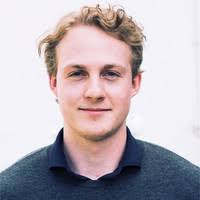

In [1113]:
data_name = "msl"

dir_path = f"../output/{data_name.upper()}"
dir_content = os.listdir(dir_path)
subfolders = [subf for subf in dir_content if os.path.isdir(f"{dir_path}/{subf}") and subf != "logs" and not subf.startswith("site_") and (subf.startswith("03062021"))]
subfolders.sort()
subfolders = subfolders[-10:]
model_id = subfolders[9]
print(subfolders)
print("Date:\t",model_id)
print(f"Found {len(subfolders)} runs.")

output_path = f"{dir_path}/{model_id}"

['03062021_001505', '03062021_002528', '03062021_003603', '03062021_004714', '03062021_010431', '03062021_011435', '03062021_012440', '03062021_013444', '03062021_014448', '03062021_015453']
Date:	 03062021_015453
Found 10 runs.


In [1114]:
if 'SMD' in output_path:
    data_name = 'SMD'
if 'SMAP' in output_path:
    data_name = 'SMAP'
if 'MSL' in output_path:
    data_name = 'MSL'
if 'TELENOR' in output_path:
    data_name = 'TELENOR'

plotter = Plotter(output_path)
plotter.result_summary()

true_anom = plotter.test_output['A_True_Global'].values
train_scores = plotter.train_output['A_Score_Global'].values
test_scores = plotter.test_output['A_Score_Global'].values

Loading results of ../output/MSL/03062021_015453
Result summary:
	TP: 7514.0
	TN: 64069.0
	FP: 1744.0
	FN: 252.0
	Avg latency: 26.24

	Precison:  0.8116
	Recall:    0.9676
	F1:        0.8827


### For MSL or SMAP
For MSL, SMAP the time series for different channels are concatinated.
Each has a file named *<data_name>_train_md.csv* that holds the length of each channel in the train data (in correct order), and also a file called *labeled_anomalies.csv* that holds information about how long the sequences for each channel is (SMAP and MSL shares this file).

In [1115]:
 # (TRAIN ERRORS): Remove errors for time steps when transition to new channel (as this will be impossible for model to predict)
if data_name in ['SMAP', 'MSL']:
    train_md = pd.read_csv(f'../datasets/data/{data_name.lower()}_train_md.csv')
    
    # Also, P-2 is not included for some reason
    train_md = train_md[train_md['chan_id'] != 'P-2']

    # Sort values by channel
    train_md = train_md.sort_values(by=['chan_id'])
    display(train_md.head())

    # Getting the cumulative start index for each channel
    sep_cuma = np.cumsum(train_md['num_values'].values) - plotter.lookback
    sep_cuma = sep_cuma[:-1]

    # Remove errors for time steps when transition to new channel (as this will be impossible for model to predict)
    buffer = np.arange(1, 50)
    i_remov = np.sort(np.concatenate((sep_cuma, np.array([i+buffer for i in sep_cuma]).flatten(),
                                    np.array([i-buffer for i in sep_cuma]).flatten())))
    i_remov = i_remov[(i_remov < len(train_scores)) & (i_remov >= 0)]
    i_remov = np.sort(np.unique(i_remov))
    if len(i_remov) != 0:
        train_scores[i_remov] = 0


chan_id  num_values
0     C-1        2158
1     C-2         764
2    D-14        3675
3    D-15        2074
4    D-16        1451

In [1116]:
 # (TEST ERRORS): Remove errors for time steps when transition to new channel (as this will be impossible for model to predict)
if data_name in ['SMAP', 'MSL']:
    md = pd.read_csv('../datasets/data/labeled_anomalies.csv')
    # If SMAP or MSL, only keep channels belonging to that dataset:
    # Also, P-2 is not included for some reason
    if 'spacecraft' in md.columns:
        md = md[md['spacecraft'] == data_name]
        md = md[md['chan_id'] != 'P-2']

    # Sort values by channel
    md = md.sort_values(by=['chan_id'])
    display(md.head())

    # Getting the cumulative start index for each channel
    sep_cuma = np.cumsum(md['num_values'].values) - plotter.lookback
    sep_cuma = sep_cuma[:-1]

   
    buffer = np.arange(1, 50)
    i_remov = np.sort(np.concatenate((sep_cuma, np.array([i+buffer for i in sep_cuma]).flatten(),
                                    np.array([i-buffer for i in sep_cuma]).flatten())))
    i_remov = i_remov[(i_remov < len(test_scores)) & (i_remov >= 0)]
    i_remov = np.sort(np.unique(i_remov))
    if len(i_remov) != 0:
        test_scores[i_remov] = 0

chan_id spacecraft             anomaly_sequences                class  \
67     C-1        MSL    [[550, 750], [2100, 2210]]  [point, contextual]   
68     C-2        MSL    [[290, 390], [1540, 1575]]  [point, contextual]   
73    D-14        MSL  [[1630, 1650], [1800, 2000]]       [point, point]   
78    D-15        MSL                [[1500, 2140]]              [point]   
79    D-16        MSL                 [[600, 1250]]         [contextual]   

    num_values  
67        2264  
68        2051  
73        2625  
78        2158  
79        2191

## Threshold method from Telemanom
This method is the one used in [Detecting Spacecraft Anomalies Using LSTMs and Nonparametric Dynamic Thresholding](https://arxiv.org/pdf/1802.04431.pdf).

In simple terms, a threshold is found that, if all values above are removed, would cause the greatest percent decrease in the mean and standard deviation of the smoothed errors es . The function also penalizes for having larger numbers of anomalous values and sequences to prevent overly greedy behavior.

In [1117]:
def find_epsilon(errors):
    e_s = errors

    sd_threshold = None
    best_epsilon = None 

    max_score = -10000000
    mean_e_s = np.mean(e_s)
    sd_e_s = np.std(e_s)

    for z in np.arange(2.5, 12, 0.5):
        epsilon = mean_e_s + sd_e_s * z
        pruned_e_s = e_s[e_s < epsilon]

        i_anom = np.argwhere(e_s >= epsilon).reshape(-1,)
        buffer = np.arange(1, 50)
        i_anom = np.sort(np.concatenate((i_anom,
                                        np.array([i+buffer for i in i_anom])
                                         .flatten(),
                                        np.array([i-buffer for i in i_anom])
                                         .flatten())))
        i_anom = i_anom[(i_anom < len(e_s)) & (i_anom >= 0)]
        i_anom = np.sort(np.unique(i_anom))

        if len(i_anom) > 0:
            groups = [list(group) for group in mit.consecutive_groups(i_anom)]
            E_seq = [(g[0], g[-1]) for g in groups if not g[0] == g[-1]]


            mean_perc_decrease = (mean_e_s - np.mean(pruned_e_s)) / mean_e_s
            sd_perc_decrease = (sd_e_s - np.std(pruned_e_s)) / sd_e_s
            score = (mean_perc_decrease + sd_perc_decrease) #/ len(i_anom)

            # sanity checks / guardrails
            if score >= max_score and len(i_anom) < (len(e_s) * 0.5):
                max_score = score
                sd_threshold = z
                best_epsilon = epsilon
    
    if best_epsilon is None:
        best_epsilon = np.max(e_s)
                
    return best_epsilon

In [1118]:
def normalize_parts(data_name):
    train_md = pd.read_csv(f'../datasets/data/{data_name.lower()}_train_md.csv')
    train_md = train_md.sort_values(by=['chan_id'])
    sep_cuma = np.cumsum(train_md['num_values'].values) - plotter.lookback
    train_epsilons = []
    s = [0] + sep_cuma.tolist()
    for c_start, c_end in [(s[i], s[i+1]) for i in range(len(s)-1)]:
        e_s = train_scores[c_start: c_end+1]
        
        e_s = (e_s - np.min(e_s))/(np.max(e_s) - np.min(e_s))
        train_scores[c_start: c_end+1] = e_s
    
    test_md = pd.read_csv('../datasets/data/labeled_anomalies.csv')
    if 'spacecraft' in test_md.columns:
        test_md = test_md[test_md['spacecraft'] == data_name]
        test_md = test_md[test_md['chan_id'] != 'P-2']

    # Sort values by channel
    test_md = test_md.sort_values(by=['chan_id'])
    sep_cuma = np.cumsum(test_md['num_values'].values) - plotter.lookback    
    s = [0] + sep_cuma.tolist()
    test_epsilons = []
    for c_start, c_end in [(s[i], s[i+1]) for i in range(len(s)-1)]:
        e_s = test_scores[c_start: c_end+1]
        e_s = (e_s - np.min(e_s))/(np.max(e_s) - np.min(e_s))
        test_scores[c_start: c_end+1] = e_s
    

## Evaluating predicted anomalies using the new threshold method

In [1119]:
normalize_parts(data_name)

Best threshold found: 0.660667397081852

Precision: 0.9468111911434193
Recall: 0.9672933286540133
F1: 0.9569376745388373
{
    "Precision": 0.9468111911434193,
    "Recall": 0.9672933286540133,
    "F1": 0.9569376745388373
}


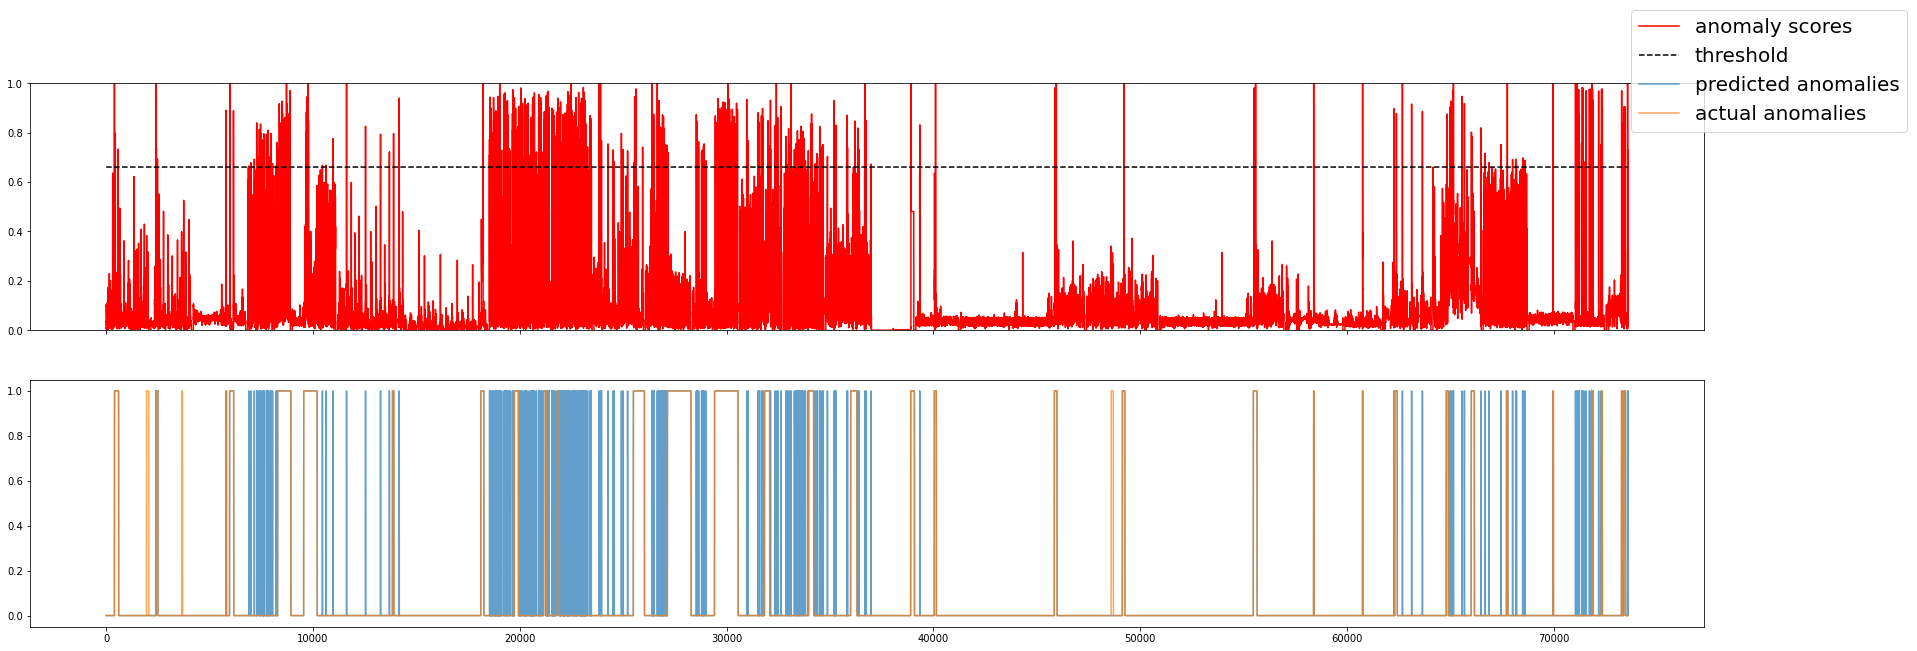

In [1120]:
fig, axs = plt.subplots(2, figsize=(30, 10), sharex=True, )

best_epsilon = find_epsilon(train_scores)
print(f'Best threshold found: {best_epsilon}\n')

pred_anom_adjusted = adjust_predicts(test_scores, true_anom, best_epsilon)
f1, precision, recall, TP, TN, FP, FN = calc_point2point(pred_anom_adjusted, true_anom)
epsilons = [best_epsilon for i in range(len(test_scores))]
        
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')

# Wonk
res_dict = {
    "Precision": precision,
    "Recall": recall,
    "F1": f1
}

print(json.dumps(res_dict, sort_keys=False, indent=4))

axs[0].set_ylim([0, np.max(test_scores)])
axs[0].plot(test_scores, c='r', label='anomaly scores')
axs[0].plot([best_epsilon]*len(test_scores), linestyle='dashed', c='black', label='threshold')
axs[1].plot(pred_anom_adjusted, label='predicted anomalies', alpha=0.7)
axs[1].plot(true_anom, label='actual anomalies', alpha=0.7)
fig.legend(prop={'size': 20})
plt.show()

# Stop
![image.png](https://media1.giphy.com/media/zCpYQh5YVhdI1rVYpE/giphy.gif)

## Interactive plot with the new threshold

In [ ]:
plotter.test_output['Thresh_Global'] = best_epsilon
plotter.test_output['A_Pred_Global'] = pred_anom_adjusted
plotter.test_output['A_Pred_0'] = pred_anom_adjusted
plotter.test_output['A_Score_0'] = test_scores
plotter.test_output['A_Score_Global'] = test_scores
plotter.train_output['A_Score_Global'] = train_scores

start, end = None, 200000
plotter.plot_channel(channel=0, plot_train=True, start=start, end=end)

### Method to get results from all subparts of SMD

['01062021_000001', '01062021_005359', '01062021_030314', '01062021_051217', '01062021_072143', '01062021_093116', '01062021_114035', '01062021_134835', '30052021_120733', '30052021_195046']
For 1-1:
 found 10 runs.
1-1: F1:	1.00

['01062021_000001', '01062021_005910', '01062021_030829', '01062021_051727', '01062021_072654', '01062021_093625', '01062021_114542', '01062021_135308', '30052021_120946', '30052021_195258']
For 1-2:
 found 10 runs.
1-2: F1:	0.96

['01062021_000001', '01062021_010336', '01062021_031252', '01062021_052154', '01062021_073119', '01062021_094045', '01062021_115005', '01062021_135700', '30052021_121143', '30052021_195454']
For 1-3:
 found 10 runs.
1-3: F1:	0.88

['01062021_000001', '01062021_010754', '01062021_031707', '01062021_052611', '01062021_073537', '01062021_094500', '01062021_115420', '01062021_140038', '30052021_121333', '30052021_195644']
For 1-4:
 found 10 runs.
1-4: F1:	0.93

['01062021_000001', '01062021_011211', '01062021_032123', '01062021_053025',

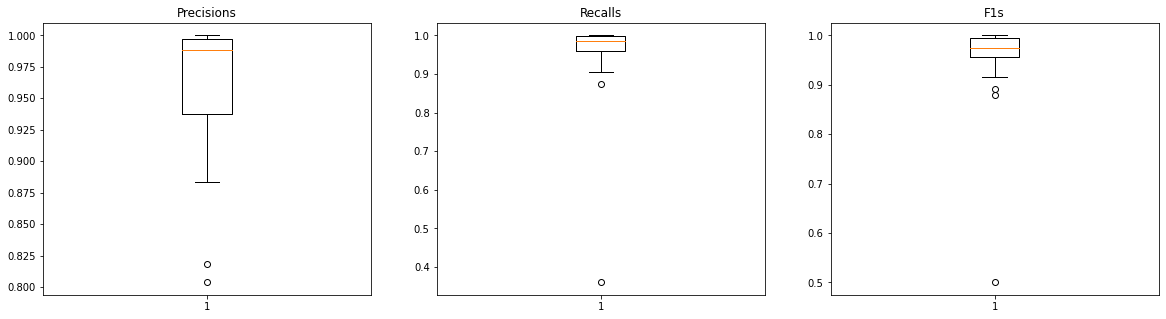

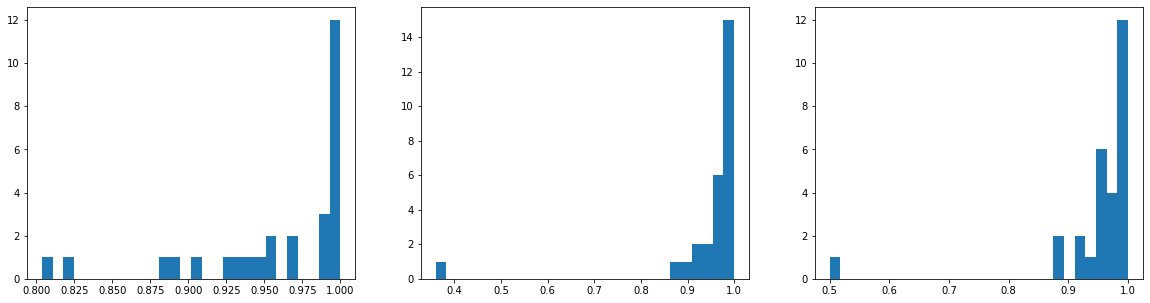

In [1143]:
# Aggregate results for all subparts of dataset 
result_dir = '../output/SMD'
precisions = []
recalls = []
f1s = []


for folder in sorted(os.listdir(result_dir)):
    if folder.startswith('threshold_config'):
        continue
    dir_content = os.listdir(f'{result_dir}/{folder}')
    subfolders = [subf for subf in dir_content if os.path.isdir(f"{result_dir}/{folder}/{subf}")
                  and subf != "logs" and not subf.startswith("site_") 
                  and (subf.startswith("0106") or subf.startswith("2905") or subf.startswith("3005"))]
    subfolders.sort()
    subfolders = subfolders[:]
    model_id = subfolders[9]
    print(subfolders)
    print(f"For {folder}:\n found {len(subfolders)} runs.")
    path = f'{result_dir}/{folder}/{model_id}/summary.txt'
    if not os.path.exists(path):
        print(f'Folder {folder} does not has a summary.txt file')
        continue
    with open(path) as f:
        result_dict = json.load(f)['bf_result']
        f1 = result_dict['f1']
        precisions.append(result_dict['precision'])
        recalls.append(result_dict['recall'])
        f1s.append(f1)
        print(f'{folder}: F1:\t{f1:.2f}\n')
print('-- Done')

precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)

print(f'Avg precision: {precisions.mean():.4f}')
print(f'Avg recall: {recalls.mean():.4f}')
print(f'Avg f1: {f1s.mean():.4f}')

# Wonk
res_dict = {
    "Precision": precisions.mean(),
    "Recall": recalls.mean(),
    "F1": f1s.mean()
}

print(json.dumps(res_dict, sort_keys=False, indent=4))

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].set_title('Precisions')
axs[0].boxplot(precisions);
axs[1].set_title('Recalls')
axs[1].boxplot(recalls);
axs[2].set_title('F1s')
axs[2].boxplot(f1s);
plt.show();

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].hist(precisions, bins=len(precisions));
axs[1].hist(recalls, bins=len(recalls));
axs[2].hist(f1s, bins=len(f1s));
plt.show();